## Import library and load model

In [2]:
from discode import utils, models

In [3]:
model = models.load("/home/sbml/jaehyung/DISCODE/weights/weights.pt")

In [4]:
model

TransformerClassifier(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=480, out_features=480, bias=True)
        )
        (linear1): Linear(in_features=480, out_features=480, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=480, out_features=480, bias=True)
        (norm1): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=480, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=2, bias=True)
)

## Make accession and sequence as variable

In [5]:
#Q9K3J3 is Streptomyces coelicolor malate dehydrogenase
name, sequence = "Q9K3J3", "MTRTPVNVTVTGAAGQIGYALLFRIASGQLLGADVPVKLRLLEITPALKAAEGTAMELDDCAFPLLQGIEITDDPNVAFDGANVALLVGARPRTKGMERGDLLEANGGIFKPQGKAINDHAADDIKVLVVGNPANTNALIAQAAAPDVPAERFTAMTRLDHNRALTQLAKKTGSTVADIKRLTIWGNHSATQYPDIFHATVAGKNAAETVNDEKWLADEFIPTVAKRGAAIIEARGASSAASAANAAIDHVYTWVNGTAEGDWTSMGIPSDGSYGVPEGIISSFPVTTKDGSYEIVQGLDINEFSRARIDASVKELSEEREAVRGLGLI"

## Predict the label of wildtype sequence

In [6]:
# The sequence need to be preprocessed with ESM-2 model
data = utils.tokenize_and_dataloader(name, sequence)

# The processed data will be transferred into model, and predict the probability, attention weights, and outlier residues
outlier_idx, probability, predicted_label, _name, attention_weights  = utils.model_prediction(data, model)

In [7]:
# The first column of probability is NAD probability, and the second column is NADP probability
print(f"The label probability of NAD is {probability.detach().numpy()[0]:.3f}, NADP is {probability.detach().numpy()[1]:.3f}")

The label probability of NAD is 0.999, NADP is 0.001


## Plot the attention sum and outlier residues

The maximum attention sum is ... 1637.513
The salient residues are ... ['A14', 'E43', 'I44', 'T45', 'G89']
The attention sum of A14 is ... 1251.161
The attention sum of E43 is ... 624.572
The attention sum of I44 is ... 1637.513
The attention sum of T45 is ... 430.036
The attention sum of G89 is ... 397.782


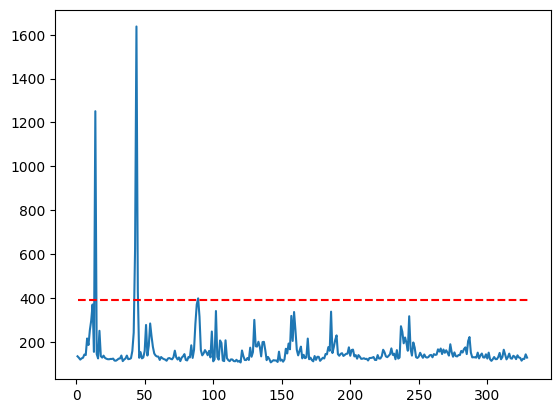

In [8]:
utils.plot_attention_sum(attention_weights, outlier_idx, sequence)

## Shortest-mode based mutation design

In [9]:
short = utils.scan_switch_mutation(model = model,
                                   max_num_mutation = 4,
                                   name = name,
                                   sequence = sequence,
                                   mode = "shortest")
short

The wildtype label probability is ...tensor([9.9906e-01, 9.3004e-04])
The mutation was derived in 2 mutations. Iteration stopped.


,NAD,NADP
Q9K3J3;E43S;I44R,0.292944,0.693356


## Iterative_num-mode based mutation design

In [10]:
iter_num = utils.scan_switch_mutation(model = model,
                                      max_num_mutation = 3,
                                      name = name,
                                      sequence = sequence,
                                      mode = "iterative_num")
iter_num

The wildtype label probability is ...tensor([9.9906e-01, 9.3004e-04])
The mutation step (('Q9K3J3',), 1) end...
The mutation step (('Q9K3J3',), 2) end...
The mutation was found in 2step


,NAD,NADP
Q9K3J3;E43S;I44R,0.292945,0.693356
Q9K3J3;E43A;I44S,0.369982,0.621812
Q9K3J3;E43V;I44S,0.466299,0.516228


## Iterative_prob-mode based mutation design

In [11]:
iter_prob = utils.scan_switch_mutation(model = model,
                                       max_num_mutation = 3,                       
                                       name = name,
                                       sequence = sequence,
                                       mode = "iterative_prob")
iter_prob

The wildtype label probability is ...tensor([9.9906e-01, 9.3004e-04])
The mutation step (('Q9K3J3',), 1) end...
The mutation step (('Q9K3J3',), 2) end...
The mutation step (('Q9K3J3',), 3) end...


,NAD,NADP
Q9K3J3;A14W;E43S;I44R,0.032487,0.966856
Q9K3J3;A14S;E43S;I44R,0.032630,0.966500
Q9K3J3;A14F;E43S;I44R,0.034164,0.965119
Q9K3J3;A14T;E43S;I44R,0.034285,0.965097
Q9K3J3;A14N;E43S;I44R,0.041305,0.957810
Q9K3J3;A14H;E43S;I44R,0.041699,0.957208
Q9K3J3;A14N;E43A;I44S,0.044097,0.956914
Q9K3J3;A14R;E43S;I44R,0.042032,0.956760
Q9K3J3;A14Y;E43S;I44R,0.043562,0.955386
Q9K3J3;A14T;E43A;I44S,0.048488,0.952378
